<a href="https://colab.research.google.com/github/khadija267/AI-for-Cyber-Security/blob/main/Network_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Label Time Series Anomaly Detection
There are nine abnormal categories.

## Get Data

Import necessary libraries

In [3]:
import pandas as pd
pd.options.display.max_columns = 100
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import torch
from google.colab import drive
from torch.utils.data import Dataset
import shutil
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import TimeSeriesSplit
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:


drive.mount('/content/drive')

# Specify the path to the file in your Google Drive
file_path = '/content/drive/My Drive/NetT_data.zip'
file_path1 = '/content/drive/My Drive/FS_description.csv'

# Copy the file to the Colab instance

shutil.copy(file_path, '.')
shutil.copy(file_path1, '.')

# Confirm that the file has been copied
!ls

Mounted at /content/drive
drive  FS_description.csv  NetT_data.zip  sample_data


In [3]:
!unzip -- NetT_data.zip

Archive:  NetT_data.zip
  inflating: NetT_data.csv           


## Data Investigation

In [4]:
metadata=pd.read_csv('FS_description.csv')
metadata.head(100)

,No.,Name,Type,Description
0,1,srcip,nominal,Source IP address
1,2,sport,integer,Source port number
2,3,dstip,nominal,Destination IP address
3,4,dsport,integer,Destination port number
4,5,cat 1,nominal,Transaction protocol
5,6,cat 3,nominal,Indicates to the state and its dependent proto...
6,7,dur,Float,Record total duration
7,8,sbytes,Integer,Source to destination transaction bytes
8,9,dbytes,Integer,Destination to source transaction bytes
9,10,sttl,Integer,Source to destination time to live value


In [5]:
df=pd.read_csv('NetT_data.csv')
df.head()


,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Bin_Label,Multi_Label
0,177.30.87.144-192.168.1.1-0-0-0,177.30.87.144,0,192.168.1.1,0,0,2019-02-04 19:53:30,115205004,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.026041,57602502.0,6.306497e+07,102196170.0,13008834.0,115205004.0,57602502.0,6.306497e+07,102196170.0,13008834.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.026041,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,5.180663e+14,8.973171e+14,1.554199e+15,1.300883e+07,0,0
1,244.15.103.115-192.168.1.79-0-0-0,244.15.103.115,0,192.168.1.79,0,0,2019-02-04 19:54:38,6039467,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.496733,3019733.5,1.373953e+06,3991265.0,2048202.0,6039467.0,3019733.5,1.373953e+06,3991265.0,2048202.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.496733,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.554199e+15,0.000000e+00,1.554199e+15,1.554199e+15,0,0
2,177.30.87.144-192.168.1.1-0-0-0,177.30.87.144,0,192.168.1.1,0,0,2019-02-04 19:55:58,65536962,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045776,32768481.0,1.564027e+07,43827824.0,21709138.0,65536962.0,32768481.0,1.564027e+07,43827824.0,21709138.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.045776,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,5.180663e+14,8.973172e+14,1.554199e+15,2.170914e+07,0,0
3,41.238.224.122-192.168.1.190-0-0-0,41.238.224.122,0,192.168.1.190,0,0,2019-02-04 19:57:37,90177027,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033268,45088513.5,4.231300e+07,75008320.0,15168707.0,90177027.0,45088513.5,4.231300e+07,75008320.0,15168707.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.033268,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,5.180664e+14,8.973172e+14,1.554199e+15,1.516871e+07,0,0
4,177.30.87.144-192.168.1.1-0-0-0,177.30.87.144,0,192.168.1.1,0,0,2019-02-04 19:58:04,111616761,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.026878,55808380.5,1.880029e+06,57137762.0,54478999.0,111616761.0,55808380.5,1.880029e+06,57137762.0,54478999.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.026878,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,5.180664e+14,8.973172e+14,1.554199e+15,5.447900e+07,0,0


In [ ]:
df.shape

In [ ]:
df.describe()

## Data Preparation

In [ ]:
df.duplicated().sum()

0

In [ ]:
# makesure that we have no missing data
df.isna().any().any()

False

In [ ]:
# Information of data columns
df.info()

In [6]:
#IP addresses is spoofed by attaker hence it is not an independent feature.
# https://www.researchgate.net/publication/309467794_A_study_on_efficient_detection_of_network-based_IP_spoofing_DDoS_and_malware-infected_Systems
df.drop(['Flow ID','Src IP','Src Port','Dst IP','Dst Port','Bin_Label'], inplace=True,axis=1)

In [ ]:
df.head(20
        )

,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Multi_Label
0,0,2019-02-04 19:53:30,115205004,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.026041,5.760250e+07,6.306497e+07,102196170.0,13008834.0,115205004.0,5.760250e+07,6.306497e+07,102196170.0,13008834.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.026041,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,5.180663e+14,8.973171e+14,1.554199e+15,1.300883e+07,0
1,0,2019-02-04 19:54:38,6039467,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.496733,3.019734e+06,1.373953e+06,3991265.0,2048202.0,6039467.0,3.019734e+06,1.373953e+06,3991265.0,2048202.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.496733,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.554199e+15,0.000000e+00,1.554199e+15,1.554199e+15,0
2,0,2019-02-04 19:55:58,65536962,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045776,3.276848e+07,1.564027e+07,43827824.0,21709138.0,65536962.0,3.276848e+07,1.564027e+07,43827824.0,21709138.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.045776,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,5.180663e+14,8.973172e+14,1.554199e+15,2.170914e+07,0
3,0,2019-02-04 19:57:37,90177027,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033268,4.508851e+07,4.231300e+07,75008320.0,15168707.0,90177027.0,4.508851e+07,4.231300e+07,75008320.0,15168707.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.033268,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,5.180664e+14,8.973172e+14,1.554199e+15,1.516871e+07,0
4,0,2019-02-04 19:58:04,111616761,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.026878,5.580838e+07,1.880029e+06,57137762.0,54478999.0,111616761.0,5.580838e+07,1.880029e+06,57137762.0,54478999.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.026878,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,5.180664e+14,8.973172e+14,1.554199e+15,5.447900e+07,0
5,0,2019-02-04 19:59:07,40255700,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.049682,4.025570e+07,0.000000e+00,40255700.0,40255700.0,40255700.0,4.025570e+07,0.000000e+00,40255700.0,40255700.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.049682,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,7.770996e+14,1.098985e+15,1.554199e+15,4.025570e+07,0
6,0,2019-02-04 20:00:37,73428081,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.040856,3.671404e+07,2.484103e+07,54279303.0,19148778.0,73428081.0,3.671404e+07,2.484103e+07,54279303.0,19148778.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.040856,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,5.180664e+14,8.973173e+14,1.554199e+15,1.914878e+07,0
7,0,2019-02-04 20:03:01,56417287,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.053175,2.820864e+07,6.880222e+06,33073695.0,23343592.0,56417287.0,2.820864e+07,6.880222e+

In [16]:
df['Protocol'].value_counts()

0    5322476
1      28107
Name: Fwd PSH Flags, dtype: int64

In [7]:
le=LabelEncoder()
df['Protocol']=le.fit_transform(df['Protocol'])

In [8]:

#after feature scaling we found the dataset contains infinte records
#to be removed from the data by replace it into NaN then to drop the Nans
df = df.replace([np.inf, -np.inf], np.nan)
df.dropna(inplace=True)

In [14]:
df.shape

(5350583, 79)

In [15]:
df.head(1)

,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Multi_Label
0,0,2019-02-04 19:53:30,115205004,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.026041,57602502.0,6.306497e+07,102196170.0,13008834.0,115205004.0,57602502.0,6.306497e+07,102196170.0,13008834.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.026041,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,5.180663e+14,8.973171e+14,1.554199e+15,13008834.0,0


In [19]:

# Convert the timestamp column to datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
#df.set_index(['Timestamp'])



## Class Imbalance Handling

0    2514059
1    2149308
2     340208
4     277696
3      36205
6      27145
5       5098
7        517
8        202
9        145
Name: Multi_Label, dtype: int64


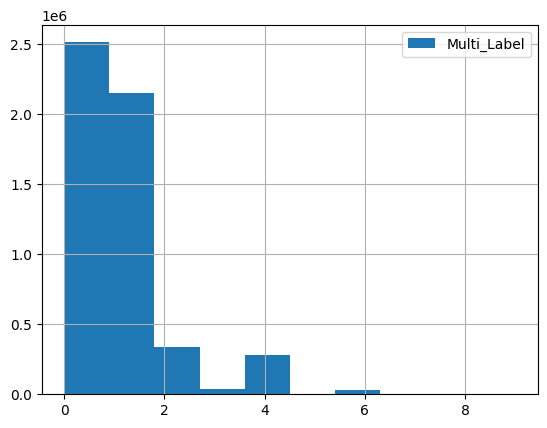

In [9]:
print(df['Multi_Label'].value_counts())
df['Multi_Label'].hist(legend=True);

In [20]:


# Separate the features and the target variable
X = df.drop('Multi_Label', axis=1)
y = df['Multi_Label']
# Split the data into training and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X,y, test_size=0.2, random_state=42,shuffle=False)

# Split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42,shuffle=False)

In [ ]:

# Define the sliding window size and stride
window_size = 10
stride = 5

# Get the timestamps for the training data
timestamps_train =X_train['Timestamp']

# Apply SMOTE with a sliding window approach to the training data
X_train_resampled = []
y_train_resampled = []
current_timestamp = timestamps_train[0]
for i in range(0, len(X_train) - window_size + 1, stride):
    window_X = X_train[i:i+window_size]
    window_y = y_train[i:i+window_size]
    print(window_timestamps)
    window_timestamps = timestamps_train[i:i+window_size]
    if window_timestamps.size > 0:
        window_timestamps=np.sort(window_timestamps)
        last_timestamp = window_timestamps[-1]
        print(last_timestamp)
    else:
        print("Array is empty")
    if last_timestamp > current_timestamp:
        # If the last timestamp in the window is greater than the current timestamp,
        # apply SMOTE to the window and append the resampled data to the resampled training data
        smote = SMOTE()
        resampled_X, resampled_y = smote.fit_resample(window_X[:, 1:], window_y)
        X_train_resampled.append(resampled_X)
        y_train_resampled.append(resampled_y)
        current_timestamp = window_timestamps[-1]

X_train_resampled = np.concatenate(X_train_resampled, axis=0)
y_train_resampled = np.concatenate(y_train_resampled, axis=0)



In [33]:
window_timestamps.dtypes
if window_timestamps.size > 0:
    window_timestamps=np.sort(window_timestamps)
    last_timestamp = window_timestamps[-1]
    print(last_timestamp)
else:
    print("Array is empty")

2019-02-04T20:03:43.000000000


In [ ]:
'''
from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils import resample

# Define the rolling window size
window_size = 1000

# Define the TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=5)

# Iterate over the folds
for train_index, test_index in tscv.split(X):
    # Split the data into training and testing sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Upsample the minority class in the training data
    minority_indices = np.where(y_train == minority_class)[0]
    majority_indices = np.where(y_train == majority_class)[0]
    minority_data = X_train[minority_indices]
    minority_interp = np.zeros_like(minority_data)
    for i in range(minority_data.shape[0]):
        f = interp1d(timestamps[train_index][minority_indices[i]:minority_indices[i]+window_size], minority_data[i], kind='linear')
        minority_interp[i] = f(timestamps[train_index][minority_indices[i]:minority_indices[i]+window_size])
    upsampled_data = np.concatenate((minority_data, minority_interp), axis=0)
    upsampled_labels = np.concatenate((np.ones(minority_data.shape[0]), np.zeros(minority_interp.shape[0])))
    X_train_resampled = np.concatenate((X_train[majority_indices], upsampled_data), axis=0)
    y_train_resampled = np.concatenate((y_train[majority_indices], upsampled_labels), axis=0)

    # Train your model on the resampled training data
    model.fit(X_train_resampled, y_train_resampled)

    # Evaluate your model on the testing data
    y_pred = model.predict(X_test)
'''

In [ ]:
from scipy.interpolate import interp1d

# Separate the minority and majority classes
minority_indices = np.where(y == minority_class)[0]
majority_indices = np.where(y == majority_class)[0]

# Upsample the minority class using linear interpolation
minority_data = X[minority_indices]
minority_interp = np.zeros_like(minority_data)
for i in range(minority_data.shape[0]):
    f = interp1d(timestamps, minority_data[i], kind='linear')
    minority_interp[i] = f(new_timestamps)
upsampled_data = np.concatenate((minority_data, minority_interp), axis=0)
upsampled_labels = np.concatenate((np.ones(minority_data.shape[0]), np.zeros(minority_interp.shape[0])))

# Combine the upsampled minority class with the majority class
X_resampled = np.concatenate((X[majority_indices], upsampled_data), axis=0)
y_resampled = np.concatenate((y[majority_indices], upsampled_labels), axis=0)

Due to the large size of the data we are going to use undersampling technique to handle class imbalance

By splitting the data before applying undersampling, we ensure that the test set remains representative of the original data

In [ ]:
X, y = df.drop(columns=['Multi_Label']), df.Multi_Label
X.shape, y.shape

((5350583, 77), (5350583,))

## Dimensionality Reduction

In [ ]:

# Load the data into a pandas DataFrame
time_df = pd.DataFrame()

# Extract the year, month, day, hour, and minute from the timestamp column
time_df['timestamp'] = pd.to_datetime(df['Timestamp'])
time_df['year'] = time_df['timestamp'].dt.year
time_df['month'] = time_df['timestamp'].dt.month
time_df['day'] = time_df['timestamp'].dt.day
time_df['hour'] = time_df['timestamp'].dt.hour
time_df['minute'] = time_df['timestamp'].dt.minute
time_df['second'] = time_df['timestamp'].dt.second

# Encode the timestamp information as a one-hot vector
year_onehot = pd.get_dummies(time_df['year'], prefix='year')
month_onehot = pd.get_dummies(time_df['month'], prefix='month')
day_onehot = pd.get_dummies(time_df['day'], prefix='day')
hour_onehot = pd.get_dummies(time_df['hour'], prefix='hour')
minute_onehot = pd.get_dummies(time_df['minute'], prefix='minute')
minute_onehot = pd.get_dummies(time_df['second'], prefix='second')

# Concatenate the one-hot vectors with the network data
data = df.drop(['Timestamp'], axis=1)
timestamps = pd.concat([year_onehot, month_onehot, day_onehot, hour_onehot, minute_onehot], axis=1)
timestamps = timestamps.to_numpy()

# Save the data and timestamps as numpy arrays
data=data.to_numpy()


In [ ]:
timestamps[0]


array([1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [ ]:
# Define the VAE architecture
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim, timestamp_dim):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.timestamp_dim = timestamp_dim

        # Encoder architecture
        self.encoder = nn.Sequential(
            nn.Linear(input_dim+timestamp_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim*2)
        )

        # Decoder architecture
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim+timestamp_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim)
        )

    # Reparameterization trick
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = mu + eps*std
        return z

    # Encoder function
    def encode(self, x, t):
        input = torch.cat((x, t), dim=1)
        h = self.encoder(input)
        mu = h[:, :self.latent_dim]
        logvar = h[:, self.latent_dim:]
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    # Decoder function
    def decode(self, z, t):
        input = torch.cat((z, t), dim=1)
        x_hat = self.decoder(input)
        return x_hat

    # VAE forward function
    def forward(self, x, t):
        z, mu, logvar = self.encode(x, t)
        x_hat = self.decode(z, t)
        return x_hat, mu, logvar

    # VAE loss function
    def loss_function(self, x_hat, x, mu, logvar):
        recon_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + kl_loss
        return loss


In [ ]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Split the data into train and test sets
split=int(0.8*len(data))
train_data = data_scaled[:split]
test_data = data_scaled[split:]

train_timestamps = timestamps[:split]
test_timestamps = timestamps[split:]

# Convert the data to PyTorch tensors
train_data = torch.from_numpy(train_data).float()
test_data = torch.from_numpy(test_data).float()

train_timestamps = torch.from_numpy(train_timestamps).float()
test_timestamps = torch.from_numpy(test_timestamps).float()

# Define the VAE hyperparameters
input_dim = train_data.shape[1]
latent_dim = 10
timestamp_dim = train_timestamps.shape[1]
lr = 0.001
epochs = 100

# Initialize the VAE and optimizer
vae = VAE(input_dim, latent_dim, timestamp_dim)
optimizer = optim.Adam(vae.parameters(), lr=lr)

# Train the VAE
for epoch in range(epochs):
    vae.train()
    optimizer.zero_grad()
    x_hat, mu, logvar = vae(train_data, train_timestamps)
    loss = vae.loss_function(x_hat, train_data, mu, logvar)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print('Epoch [%d/%d], Loss: %.4f' % (epoch+1, epochs, loss.item()))

# Evaluate the VAE on the test set
vae.eval()
test_z, _, _ = vae.encode(test_data, test_timestamps)
test_x_hat = vae.decode(test_z, test_timestamps)

# Use the VAE latent space for classification
# You can train a classifier on the VAE latent space
# or use clustering algorithms to identify abnormal classes

Epoch [1/100], Loss: 66312132.0000
Epoch [11/100], Loss: 33733240.0000


In [ ]:
0.8*len(data)

4280466.4

##normalization and arbitray features selection

MaxMin normalization and select 10 features randomly

(F1) 93 with LSTM and 98 for RF but multi-classes 66 (LSTM) 87 (RF)

##  Feature Extraction

In [ ]:
'''
import numpy as np
import pandas as pd


# Load the data
data = pd.read_csv('data.csv')

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data.drop('target', axis=1), data['target'], test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

# Define the V-AE model
input_dim = X_train_norm.shape[1]
latent_dim = 10

input_layer = Input(shape=(input_dim,))
hidden_layer_1 = Dense(64, activation='relu')(input_layer)
hidden_layer_2 = Dense(32, activation='relu')(hidden_layer_1)
z_mean = Dense(latent_dim)(hidden_layer_2)
z_log_var = Dense(latent_dim)(hidden_layer_2)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

z = Lambda(sampling)([z_mean, z_log_var])
decoded = Dense(input_dim, activation='sigmoid')(z)

vae = Model(input_layer, decoded)
vae.compile(optimizer='adam', loss='mean_squared_error')

# Train the V-AE model
vae.fit(X_train_norm, X_train_norm, epochs=10, batch_size=32)

# Extract features from the V-AE model
encoder = Model(input_layer, z_mean)
X_train_encoded = encoder.predict(X_train_norm)
X_test_encoded = encoder.predict(X_test_norm)

# Train a LightGBM model
model = lgb.LGBMClassifier()
model.fit(X_train_encoded, y_train)

# Evaluate the LightGBM model
y_pred = model.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))
'''

In [ ]:

#!pip install keras==2.1.6

In [ ]:
'''
import numpy as np
import pandas as pd
import random

from keras.models import Sequential
from keras.layers.core import Dense, Activation

from keras.layers.recurrent import LSTM
from keras.layers import Input, LSTM, RepeatVector, Masking, TimeDistributed, Lambda
from keras.losses import mse, binary_crossentropy, mean_squared_error
from keras.models import Model
from keras import backend as K


#define variables
latent_dim=9
Intermediate_dim=6
nb_epoch=1000
batch_size=100
optimizer='adam'
#X is the data matrix

#encoder LSTM
inputs = Input(shape=(7, 1), name='InputTimeSeries')  #(timesteps, input_dim)
encoded = LSTM(Intermediate_dim, name='EncoderLSTM')(inputs) # intermediate dimension

#Creating mean and sigma vectors
z_mean = Dense(latent_dim, name='MeanVector' )(encoded)
z_log_sigma = Dense(latent_dim,name='SigmaVector')(encoded)

#latent vector sampling
def sampling(args):
    z_mean, z_log_sigma = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_sigma) * epsilon

z = Lambda(sampling, name='LatentVector', output_shape=(latent_dim,))([z_mean, z_log_sigma])

#VAE Loss
def vae_loss(inputs, decoded):

    xent_loss = K.sum(K.binary_crossentropy(inputs, decoded), axis=1)
    kl_loss = - 0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return K.mean(xent_loss + kl_loss)


#decoder LSTM
decoded = RepeatVector(7, name='EmbeddingtoTimeSeries')(z) #timesteps
decoded = LSTM(Intermediate_dim,name='DecoderLSTM1', return_sequences=True)(decoded) #intermediate dimensions
decoded = LSTM(1,name='DecoderLSTM2', return_sequences=True)(decoded) #input_dim

#decoded=TimeDistributed(Dense(1, name='Wrapper'), name='TimeDistributed')(decoded)

v_autoencoder = Model(inputs, decoded)
encoder = Model(inputs, z_mean)
#v_autoencoder.summary()

v_autoencoder.compile(optimizer=optimizer, loss=vae_loss)
v_autoencoder.fit(X,X,nb_epoch=nb_epoch,batch_size=batch_size)

# Obtain latent
train_latent = encoder.predict(X_train)[2]

'''

## Modeling

### RF

### lightGB

### LSTM

((5351760, 78), (5351760,))

In [ ]:
#mm = MinMaxScaler()
ss = StandardScaler()

X_trans = ss.fit_transform(X_train.values.reshape(-1, 1))
y_trans = y_train

In [ ]:

# Set up the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(input_size=X.shape[1], hidden_size=32, num_layers=1, output_size=1)
model.to(device)

# Set up the time-series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Set up the loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Run the cross-validation
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Convert the data to PyTorch tensors
    X_train = torch.Tensor(X_train).unsqueeze(2).to(device)
    y_train = torch.Tensor(y_train).to(device)
    X_test = torch.Tensor(X_test).unsqueeze(2).to(device)
    y_test = torch.Tensor(y_test).to(device)

    # Train the LSTM model
    for epoch in range(10):
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate the LSTM model on the test set
    with torch.no_grad():
        outputs = model(X_test)
        predicted = torch.round(torch.sigmoid(outputs))
        accuracy = (predicted == y_test).sum().item() / len(y_test)
        print('Accuracy:', accuracy)

### TCN

### attention mechanism.